# Analyzing NYC High School Data

In this project, we will explore the relationships between SAT scores and demographic factors in New York City public schools. 

The [SAT](https://en.wikipedia.org/wiki/SAT) or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each with a max of 800 points. 

High average SAT scores are usually indicative of a good high school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets. We will combine the following disparate data sets into a single, clean pandas dataframe:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduaton outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

NYC has a significant immigrant population and is very diverse, so comparing demographic factos such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test and that is what we will begin to explore.

# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Exploring Population vs. SAT Scores
Because enrollment seems to have such a strong correlation, let's explore total_enrollment vs sat_score. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

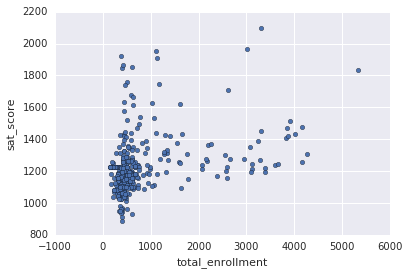

In [10]:
#Make a scatter plot and check correlation
combined.plot.scatter(x='total_enrollment', y='sat_score')


Upon examining the scatter plot we can see that the correlation seems to come from the fact that the schools with fewer students are performing poorly, and not necessarily that the schools with more students are performing particularly well. This could be due to a variety of factors, but the first step is taking a closer look at the most interesting part of the graph above: the clump of schools with lower than 1000 students which all performed relatively poorly (i.e., scored less than 1000 on average).

Another important factor to bear in mind is that lower enrollment means smaller schools, and smaller schools tend to have [lessened capacity for college preparation](https://www.gao.gov/products/gao-19-8).

In [11]:
filter1 = combined['total_enrollment'] < 1000
low_enrollment = combined[filter1]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]
low_enrollment['School Name'].unique()

array(['INTERNATIONAL COMMUNITY HIGH SCHOOL', 0,
       'BRONX INTERNATIONAL HIGH SCHOOL',
       'KINGSBRIDGE INTERNATIONAL HIGH SCHOOL',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'HIGH SCHOOL OF WORLD CULTURES',
       'BROOKLYN INTERNATIONAL HIGH SCHOOL',
       'INTERNATIONAL HIGH SCHOOL AT PROSPECT',
       'IT TAKES A VILLAGE ACADEMY', 'MULTICULTURAL HIGH SCHOOL',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOO'], dtype=object)

Immediately, it has become apparent that all of these schools are going to have a significant number of English as Second Language (ESL) students. To see how that affects SAT score independantly we can check the correlation between sat_score and ell_percent above (strong negative correlation) and check the scatter plot for all schools.

## Exploring English as a Second Language vs. SAT Score

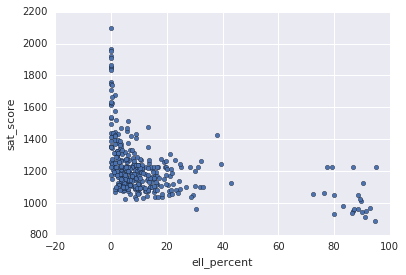

In [12]:
#Plotting a scatter for ell percent vs SAT Score
combined.plot.scatter(x='ell_percent', y = 'sat_score')

While the divide is clear, schools who have a higher percentage of ESL students tend to have lower SAT scores on average. Perhaps the SAT is unfavorable to those whose English language skills are not very strong (reasonable, since a large portion (two-thirds) of the SAT is based on English comprehension). Perhaps also those schools with higher-than-average ESL students also have lower budgets and therefore less financial freedom to help educate their students in preparation for standardized testing, due to their already greater fiscal strain of across-the-board ESL classes.

# Exploring and Plotting survey correlations

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

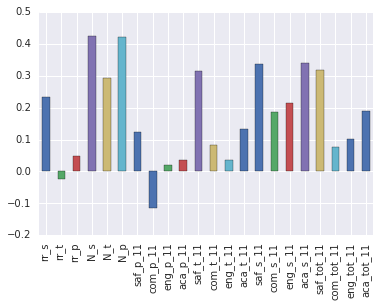

In [14]:
#Find the correlations between the survey fields and sat_score and plotting
combined.corr()['sat_score'][survey_fields].plot.bar()

Looking at the correaltions between survey data and sat scores, big picture looks like there seems to be a majority of positive correlations between survey data and SAT scores, with little negative correlative relationships.

Looking at some of the more stronger correlations (above .25), we can see columns **N_s, N_t, N_p, saf_t_11, saf_s_11, aca_s_11, and saf_tot_11** hold the strongest correlations with SAT scores.

Looking at the data dictionary for these columns, held [here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), these fields description as follows:

- N_s: Number of student respondents
- N_t: Number of teacher respondents
- N_p: Number of parent respondents
- saf_t_11: Safety and Respect score based on teacher responses
- saf_s_11: Safety and Respect score based on student responses
- aca_s_11: Academic expectations score based on student responses
- saf_tot_11: Safety and Respect total score

Some interesting, while not as correlativing strong, is:

- rr_s: Student Response Rate
- eng_s_11: Engagement score based on student responses

Looking at this context, we can make some initial observations:

- It seems the higher number of responses taken from the survey, supplimented with highter student response rate, the higher the SAT Scores. Since this would directly be affected by Total Enrollment, this makes sense. Also, as surveys tend to be optional and volunteered, this could indicate a positive demeanor at schools where students, teachers and parents want their voices heard and see efficacy in their effect on their education. Higher engagement in education may cross over in students to achieve better on tests, including SAT.

- To that point, it also looks like the higher the safety, respect and academic expectations between students and teachers, the higher the SAT scores. This could indicate where students have a healthy relationship with their teachers and schools, while feeling safe and secure, fosters a environment that nurtures engaged students who perform better on tests.



## Exploring Safety and SAT Scores

Based on the above, we have determined that saf_t_11 and saf_s_11, which measures how teachers and students perceive safety at school, correlated highly with sat_score. Let's dig into that a bit more.

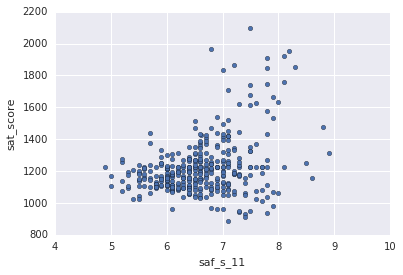

In [15]:
#Scatter plot of saf_s_11 & sat_score
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

As we can further see, there is a slight positive relationship as students perceived safety at school rises, so does SAT scores. There seems to be a large collection of scores that stay relatively flat between scores of 5 - 7, and as safety scores rise do we see a stronger relationship. There a few schools with relatively high safety and SAT Scores, with no school 6.5 having scores highter than 1500.

Let's now compute the average safety score of each borough.

In [16]:
#First let's group our safety scores by borough.
boros = combined.groupby('boro').agg(np.mean)['saf_s_11']
boros.sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

Looking at the average safety scores across the five boroughs, it looks like Manhatten and Queens have the highest safety score and Brooklyn, Staten Island having the lowest. Manhatten may make sense to it being the business, financial and entertainment/arts hub of the city and state. Brooklyn is the most populous of the boroughs and most diverse. Seeing that Brooklyn median income is lower compared to the other boroughs, that may paint a picture as to why the lower safety score.

## Exploring Race and SAT Scores

Now lets explore the relationship between race and SAT Scores.

There are a few columns that indicate the percentage of race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

Let's plot the correlations between these columns and sat_score to see any racial differences

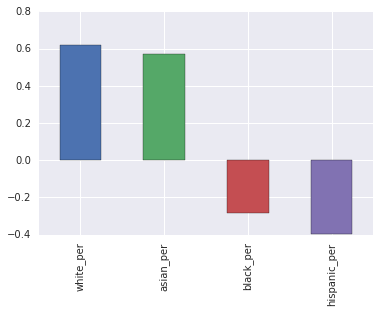

In [17]:
race_cols = ['white_per',
            'asian_per',
            'black_per',
            'hispanic_per'
            ]

combined.corr()['sat_score'][race_cols].plot.bar()

We see a strong correlations (around 0.6) for schools with a higher percentage of white and asian students and SAT Scores, compared to the negative correlations between those schools with higher percentage of black and hispanic students (around -0.4), showing a bit of racial disparity. When looking at the above Brooklyn Safety info, certain neighborhoods with more ethically diverse population may have not as many resources for students or may be in areas that are perceived not as safe. 

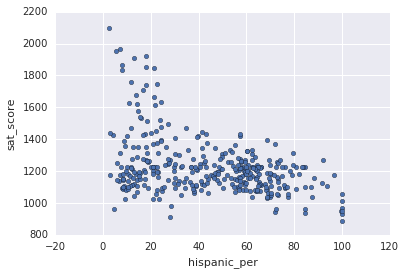

In [18]:
#Explore schools with low SAT Scores and high hispanic_per
combined.plot.scatter(x='hispanic_per', y='sat_score')

Looks like there a number of high performing schools where the hispanic student percentage is less then 35%, with the highest performers having less than 10%

In [19]:
#Pull schools where hispanic_per > 95%
high_hispanic = combined[combined['hispanic_per'] > 95]
high_hispanic['school_name']

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

It looks like the schools where the hispanic percentage is very high, tends to be schools that service a diverse community. Resources may be sparse and students may be first-generation and come from immigrant families who may be concurrently learning English ASL. 

In [20]:
#Pull schools where hispanic_per < 10% and sat_score > 1800
low_hispanic = combined[combined['hispanic_per'] < 10]
low_hispanic = low_hispanic[low_hispanic['sat_score'] > 1800]
low_hispanic['school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

It looks like many of these schools specialize in gifted students or those that specialize in STEM subjects, that would benefit and correlate with high performing students (who test well). While not specific to hispanic_per, it does give insight into types of schools and who and who doesn't attend. 

## Exploring Gender and SAT Scores

Let's now look at the relationship between gender and scores.

Two columns indicate the percentage of each gender at a school:

- male_per
- female_per

Let's plot the correlations 

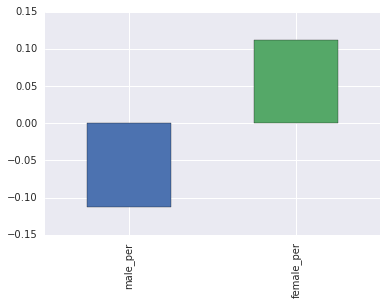

In [21]:
#Make a bar plot of correlations for gender

gender_cols = ['male_per',
              'female_per'
              ]

combined.corr()['sat_score'][gender_cols].plot.bar()


While not as strong of correlations, it looks like schools with higher female populations have higher test scores, perhaps highlighting females perform better on tests then male populations. 

Let's investigate further

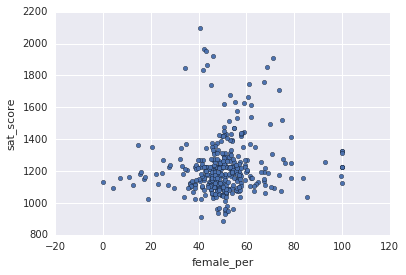

In [22]:
#Scatter plot for female_per and sat_score
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

The scatter plot shows a weak  to no correlation, but it looks like a few high performing schools where the female_per is more than 50% have scores higher than 1600.

In [23]:
#Research schools where female_per is > 60% an SAT > 1700
high_female = combined[combined['female_per'] > 60]
high_female = high_female[high_female['sat_score'] > 1700] 
high_female['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

Looking at the above high performing and female heavy schools, they tend to be in Manhatten with a good amount of resources and a strong demeanor towwards college prep - being selective liberal arts schools with high academic standards.

## Exploring AP Scores vs. SAT Scores

Finally, let's explore the relationship between AP Test Scores and sat_scores. Based on AP Classes being made to simulate the rigor of college level coursework, it would make sense to see a postive relationship between those who performed well on those exams and the SAT. 

Let's look at the percentage of students in each school who took at least 1 AP Exam.

In [24]:
#Calculate percentage of students in each school that took an AP Exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

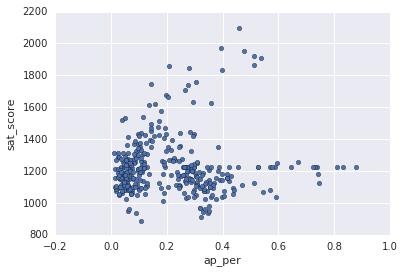

In [25]:
#Scatter plot of ap_per vs. sat_score
combined.plot.scatter(x='ap_per', y='sat_score')

In [26]:
combined.corr()['sat_score']['ap_per']

0.05717081390766967

It looks like there is a slight positive correlation between those schools with AP Test Takers and SAT Score. Calculating the actual correlation, it's fairly small.

## Exploring Class Size and SAT Scores

In [27]:
pd.set_option('display.max_columns', None)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,0

In [28]:
#Finding correlation between AVERAGE CLASS SIZE and sat score
combined.corr()['AVERAGE CLASS SIZE']['sat_score']

0.3810143308095523

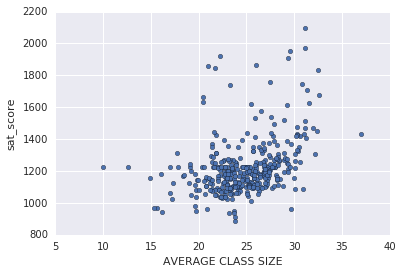

In [29]:
#Scatter plot the relationship
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

There seems to be a slight postive correlation between the average class size and sat scores, which could be a matter of larger sample size that could skew the data higher or, at the risk of misattribution, larger classes sizes on average may create a competitive environment for higher performance.

## Inequality of Poverty

Based on our analysis thus far, a couple of strong correlations have been found:

- Smaller schools do slightly worse overall
- Larger number of ESL students means worse scores on average
- Black and Hispanic populaces typically suffer from worse scores, but the schools with higher black/hispanic populations and lower scores had high rates of poverty.
- A feeling of safety has a somewhat positive correlation with SAT scores
- Higher number of AP test takers means higher SAT scores.
- Most of these, with the exception of safety (where the average student safety was relatively unimpacted by surrounding poverty levels), are directly correlated to poverty issues. To take a closer look at this, we'll examine the percentage of students receiving free or reduced-cost lunches.

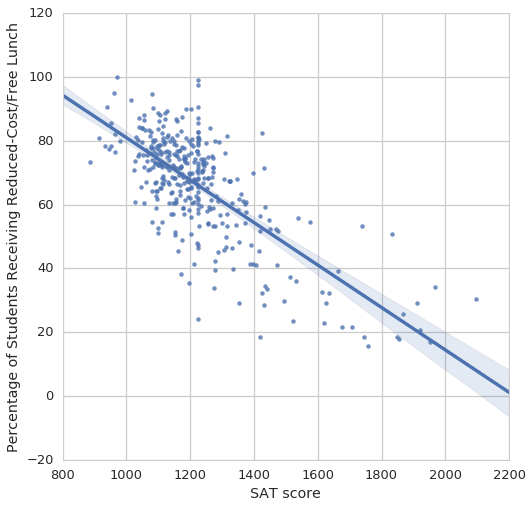

In [30]:
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8,8))
sns.regplot(x='sat_score', y='frl_percent', data=combined)
plt.xlabel('SAT score')
plt.ylabel('Percentage of Students Receiving Reduced-Cost/Free Lunch')

In [31]:
combined.corr()['sat_score']['frl_percent']

-0.7222246349966357

It's very clear: the higher the percentage of students with financial-aid for lunch, the lower the average SAT Scores. 

## Conclusion

There are a variety of factors that play into a school's average SAT scores. The common factor, however, is money. The schools with lower funding tend to have fewer AP classes which means they have fewer students preparing specifically for college readinesss. Schools with higher percentages of ESL students spend more of their budget focusing on teaching English to their foreign language students. And most prominently: schools with higher percentages of students receiving lunch assistance have lower SAT scores on average.

Money talks louder than any other factor. Students of poverty must spend larger portions of their time outside of school dedicated to survival and must overcome larger hurdles put in place by socioeconomic disadvantage. Examples of poverty-induced hurdles:

- Many high school students in poverty have to work to help with bills/rent/etc, which can [negatively impact their schoolwork](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2936460/), if the family is already in poverty.
- Many have to help with chores around the house while their parents/guardians work second or even third jobs.
- Some have to rely on [reduced nutrients and cognition due to diet](http://www.ascd.org/publications/educational-leadership/may13/vol70/num08/How-Poverty-Affects-Classroom-Engagement.aspx).
- Employed parents in poverty are least likely to get [access to the support infrastructures their children need](https://files.eric.ed.gov/fulltext/EJ1029033.pdf).
- Poor students tend to live in [regions with under-funded schools](https://www.irp.wisc.edu/publications/focus/pdfs/foc332e.pdf).
- Under-funded schools tend to [lack the funding for advanced classes](https://www.gao.gov/products/gao-19-8) which lead to lower levels of college preparedness.